# Read Me
- Dalam kasus ini, saya akan menggunakan 2 cara yaitu cara pertama mengikuti intsruksi dan cara 2 adalah sedikit modifikasi yang akan saya lakukan.

# Cara Pertama Sesuai Instruksi
***

## 0. Load Library
- Memuat library yang akan digunakan.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import itertools
import warnings
warnings.filterwarnings('ignore')

## 1. Load Datasets

In [2]:
#Memuat data
df = pd.read_csv('water.csv', skipfooter=2)

In [3]:
#melihat kolom yang ada di data
df.columns

Index(['Year', 'Baltmore city annual water use, liters per capita per day, 1885-1968'], dtype='object')

In [4]:
#replace columns agar lebih enak
rename={'Year':'year',
        'Baltmore city annual water use, liters per capita per day, 1885-1968':'annual_use'}
df.rename(columns=rename, inplace=True)

In [5]:
#Split data 2 model development and validation
batas = len(df) - 20
dataset, validation = df[0:batas], df[batas:]

#simpan dataset dan validation dalam bentuk csv
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

## 2. Create summary of the dataset, with python function.
- Mulai sekarang akan menggunakan data untuk model development yaitu dataset.csv

In [6]:
#copy dataset ke dalam df
df = dataset.copy()
df.describe()

,year,annual_use
count,59.000000,59.000000
mean,1914.000000,485.288136
std,17.175564,68.033473
min,1885.000000,344.000000
25%,1899.500000,454.000000
50%,1914.000000,485.000000
75%,1928.500000,509.000000
max,1943.000000,662.000000


- Jumlah data dataset 59.
- rata rata penggunaan water di baltimore sebesar 485.28 per tahun.

## 3. Create A line plot of a time series dataset, it will provide a lot of insight into the problem.

Text(0.5, 1.0, 'Annual Use of Water in Baltimore')

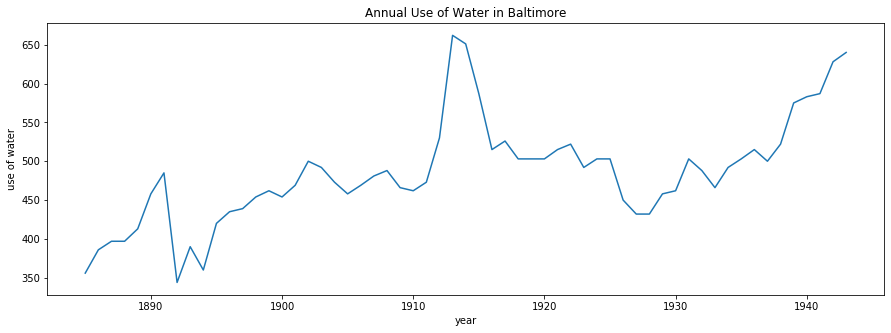

In [7]:
#membuat line plot dari data
f = plt.figure(figsize=(15,5))

f.add_subplot(1,1,1)
plt.plot(df['year'], df['annual_use'])
plt.xlabel('year')
plt.ylabel('use of water')
plt.title('Annual Use of Water in Baltimore')

- Dari line plot dapat dilihat bahwa data memiliki trend.

## 4. Group the annual data by decade and get an idea of the spread of observations for each decade and how this may be changing.

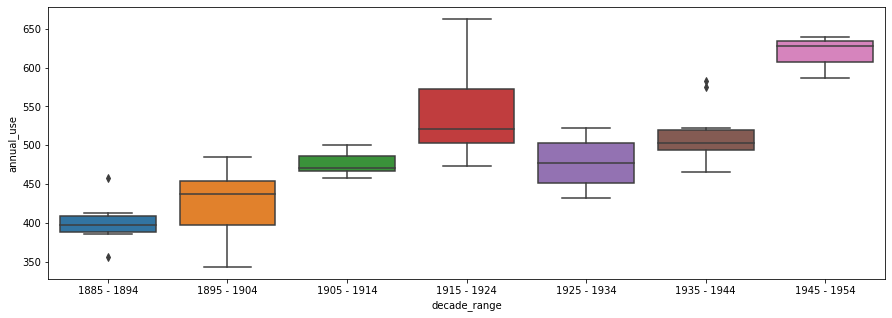

In [8]:
# NEAREST 10 FOR DECADE START
df['decade_start'] = (df['year'] // 10) * 10 + 5

# ADJUST FOR YEARS ENDING IN ZERO
df.loc[(df['year'] % 10) == 0, 'decade_start'] = df['decade_start'] - 10

# CALCULATE DECADE RANGE
df['decade_range'] = df['decade_start'].astype('str') + ' - ' + \
                     (df['decade_start'] + 9).astype('str') 

plt.figure(figsize=(15,5))
sns.boxplot(x="decade_range", y="annual_use", data=df)   

plt.show()
plt.clf()
plt.close()

## 5. Create models using ARIMA

### 5.1 Split Dataset

In [9]:
#copy dataset ke df agar dataset tidak berubah
df = dataset.copy()

In [10]:
#Membuat features year menjadi index
df.set_index(df['year'], inplace=True)

#Menghapus feature year
df.drop(columns=['year'], inplace=True)

In [11]:
#Mengubah data menjadi float
df = df.astype('float64')

#Split data menjadi training dan testing dengan proporsi 80:20
train_size = int(len(df)*0.8)
train = df[0:train_size]
test = df[train_size:]
print(train.shape)
print(test.shape)

(47, 1)
(12, 1)


### 5.2 Use an ARIMA(0,1,0) on the raw data may be a good starting point.

In [12]:
#melihat hasil dari arima
arima_order = (0,1,0)
arima = ARIMA(train, order=arima_order)
arima_fit = arima.fit()
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.annual_use   No. Observations:                   46
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -234.089
Method:                           css   S.D. of innovations             39.250
Date:                Thu, 10 Oct 2019   AIC                            472.179
Time:                        18:11:10   BIC                            475.836
Sample:                             1   HQIC                           473.549
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1957      5.787      0.552      0.584      -8.147      14.538


### 5.3 Prediction

In [13]:
#Nilai prediksi dari model
y_pred = arima_fit.forecast(len(test))[0]
df_test = pd.DataFrame(y_pred, columns=['prediksi'], index=test.index)
df_test['actual'] = test.values
df_test.head()

,prediksi,actual
year,,
1932,506.195652,488.0
1933,509.391304,466.0
1934,512.586957,492.0
1935,515.782609,503.0
1936,518.978261,515.0


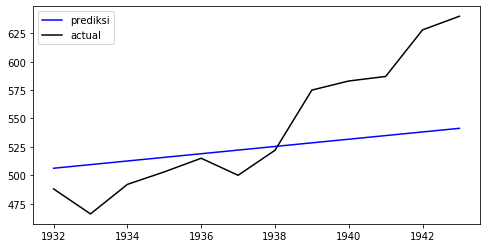

In [14]:
#Actual vs Forecasted in test dataset
plt.figure(figsize=(8,4))
plt.plot(df_test['prediksi'], color='blue', label='prediksi')
plt.plot(df_test['actual'], color='black', label='actual')
plt.legend()
plt.show()

## 6. Calculate RMSE and MAPE

In [15]:
#check error
rmse = np.sqrt(mean_squared_error(df_test['actual'], df_test['prediksi']))
print(f'Nilai RMSE {rmse}')

Nilai RMSE 48.832206147970616


- Model pertama didapatkan nilai RMSE yaitu 48.8.

***
# Cara Kedua Menggunakan Sedikit Modifikasi
- Tetap menggunakan data dataset

In [16]:
df = dataset.copy()

In [17]:
#Mengubah features year kedalam bentuk datetime
df['year'] = pd.to_datetime(df['year'], format='%Y')

#Menjadikan feature year sebagai index
df.set_index(df['year'], inplace=True)

#menghapus feature year
df.drop(columns=['year'], inplace=True)

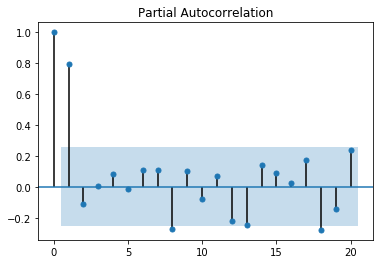

In [18]:
#Plot PACF
plot_pacf(df, lags=20)
plt.show()

- Signifikan di Lag 0 dan 1

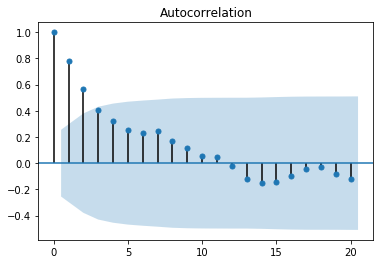

In [19]:
#Plot ACF
plot_acf(df, lags=20)
plt.show()

- Signfikan di Lag 0,1, dan 2

### Check the Seasonality
- Untuk mengetahui apakah data memiliki efek musiman dan trend.

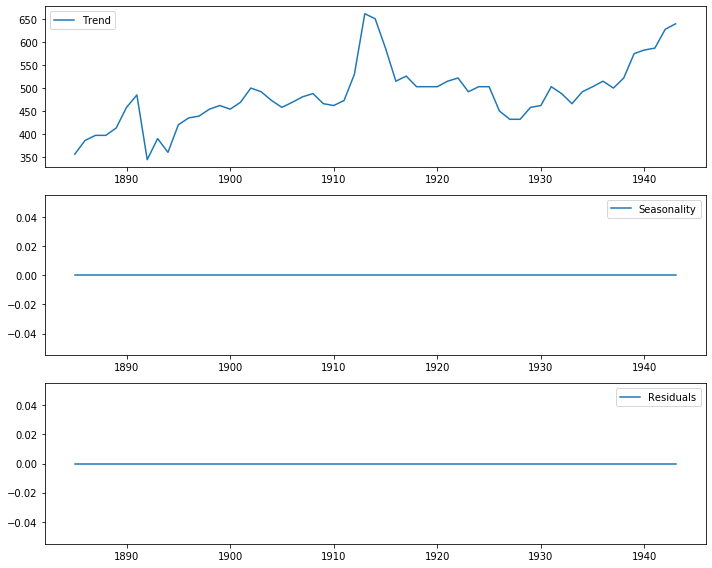

In [20]:
decomposition = seasonal_decompose(df['annual_use'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(10,8))
plt.subplot(311)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(312)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(313)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- Data memiliki sedikit trend.
- Data tidak memiliki komponen musiman.

### Check the Stationarity

In [21]:
#melakukan adfuller test untuk check apakah data stasioner atau tidak
adftest = adfuller(df['annual_use'], autolag='AIC')

In [22]:
#melihat output dari adfuller test
adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
adf_output

Test Statistic                 -1.833141
p-value                         0.364136
#Lags Used                      2.000000
Number of Observations Used    56.000000
dtype: float64

- Karena nilai p-value lebih dari 0.05 maka, H0 diterima yaitu data belum stasioner.

### Differencing 1x
- Dilakukan agar data stasioner.

In [23]:
#differencung 1
diff1 = df - df.shift(1)

#menghapus null values
diff1 = diff1.dropna()

In [24]:
#melihat kembali adfuller test
adftest = adfuller(diff1['annual_use'], autolag='AIC')
adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
adf_output

Test Statistic                 -5.615617
p-value                         0.000001
#Lags Used                      1.000000
Number of Observations Used    56.000000
dtype: float64

- Nilai p-value sudah dibawah 0.05 maka data sudah stasioner dan bisa dilanjutkan ke tahap modelling.
- Nilai d harus 1 karena dilakukan differencing sebanyak 1x.

### Modelling

In [25]:
#Mengubah data menjadi float
df = df.astype('float64')

#Split data menjadi training dan testing dengan proporsi 80:20
train_size = int(len(df)*0.8)
train = df[0:train_size]
test = df[train_size:]
print(train.shape)
print(test.shape)

(47, 1)
(12, 1)


In [26]:
#Membuat fungsi untuk mencari parameter pdq terbaik
def find_best_pdq(train, px, dx, qx):
    train = train.astype('float64')
    best_score, best_cfg = float("inf"), None
    for p in px:
        for d in dx:
            for q in qx:
                order = (p,d,q)
                try:
                    arima_order = (p,d,q)
                    arima = ARIMA(train, order=arima_order)
                    arima_fit = arima.fit()
                    y_pred = arima_fit.forecast(len(test))[0]
                    rmse = np.sqrt(mean_squared_error(test, y_pred))
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [27]:
#Mencari nilai pdq terbaik
p = range(0, 5)
d = range(0, 3)
q = range(0, 5)
find_best_pdq(train, p, d, q)

Best ARIMA(4, 1, 1) RMSE=44.346


Didapatkan kombinasi pdq terbaik adalah 4,1,1 dengan RMSE 44.346

In [28]:
arima_order = (4,1,1)
arima = ARIMA(train, order=arima_order)
arima_fit = arima.fit()
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.annual_use   No. Observations:                   46
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -230.516
Method:                       css-mle   S.D. of innovations             35.463
Date:                Thu, 10 Oct 2019   AIC                            475.033
Time:                        18:11:30   BIC                            487.833
Sample:                    01-01-1886   HQIC                           479.828
                         - 01-01-1931                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.6154      1.322      1.979      0.055       0.025       5.206
ar.L1.D.annual_use     0.8847      0.148      5.986      0.000       0.595       1.174
ar.L2.D.annual_use  

In [29]:
#Nilai prediksi dari model
y_pred = arima_fit.forecast(len(test))[0]
df_test = pd.DataFrame(y_pred, columns=['prediksi'], index=test.index)
df_test['actual'] = test.values
df_test.head()

,prediksi,actual
year,,
1932-01-01,511.082833,488.0
1933-01-01,519.459692,466.0
1934-01-01,518.242362,492.0
1935-01-01,522.853049,503.0
1936-01-01,527.239028,515.0


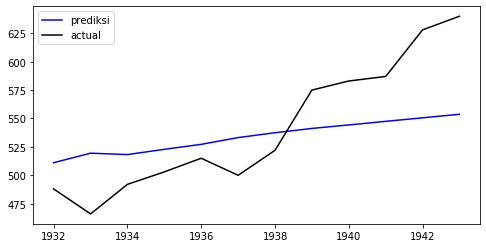

In [30]:
#Actual vs Forecasted in test dataset
plt.figure(figsize=(8,4))
plt.plot(df_test['prediksi'], color='blue', label='prediksi')
plt.plot(df_test['actual'], color='black', label='actual')
plt.legend()
plt.show()

In [31]:
#check error
rmse = np.sqrt(mean_squared_error(df_test['actual'], df_test['prediksi']))
print(f'Nilai RMSE {rmse}')

Nilai RMSE 44.346244421119415


# Kesimpulan
- Data memiliki efek trend dan harus di differencing sebanyak 1x.
- Setelah melakukan training, didapatkan Arima model terbaik adalah dengan komposisi pdq (4,1,1) dengan nilai RMSE sebesar 44.34.
- Selanjutnya adalah melakukan prediksi menggunakan model arima (4,1,1) untuk data validation.csv.

## Prediksi Untuk Data Validation.csv

In [32]:
#load data validation
validation = pd.read_csv('validation.csv')

In [33]:
#Mengubah features year kedalam bentuk datetime
validation['year'] = pd.to_datetime(validation['year'], format='%Y')

#Menjadikan feature year sebagai index
validation.set_index(validation['year'], inplace=True)

#menghapus feature year
validation.drop(columns=['year', 'Unnamed: 0'], inplace=True)

In [34]:
#Training ARIMA ini menggunakan seluruh data yang ada di dataset.
arima_order = (4,1,1)
arima = ARIMA(df, order=arima_order)
arima_fit = arima.fit()
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.annual_use   No. Observations:                   58
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -287.368
Method:                       css-mle   S.D. of innovations             33.700
Date:                Thu, 10 Oct 2019   AIC                            588.737
Time:                        18:11:31   BIC                            603.160
Sample:                    01-01-1886   HQIC                           594.355
                         - 01-01-1943                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.2694      1.171      2.792      0.007       0.974       5.565
ar.L1.D.annual_use     0.9108      0.132      6.916      0.000       0.653       1.169
ar.L2.D.annual_use  

In [35]:
#Nilai prediksi dari model
y_pred = arima_fit.forecast(len(validation))[0]
df_validation = pd.DataFrame(y_pred, columns=['prediksi'], index=validation.index)
df_validation['actual'] = validation.values
df_validation.tail()

,prediksi,actual
year,,
1959-01-01,634.878531,594
1960-01-01,637.760906,587
1961-01-01,640.706713,587
1962-01-01,643.704566,625
1963-01-01,646.747343,613


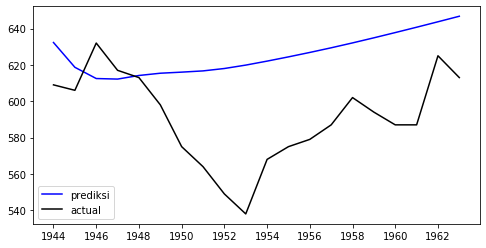

In [36]:
#Actual vs Forecasted in test dataset
plt.figure(figsize=(8,4))
plt.plot(df_validation['prediksi'], color='blue', label='prediksi')
plt.plot(df_validation['actual'], color='black', label='actual')
plt.legend()
plt.show()

In [37]:
#check error
rmse = np.sqrt(mean_squared_error(df_validation['actual'], df_validation['prediksi']))
print(f'Nilai RMSE {rmse}')

Nilai RMSE 42.60480028778552


- Didapatkan ternyata RMSE dari data validation.csv didapatkan 42 yang tidak jauh beda dengan RMSE dari model yaitu 44.
- Bisa dikatakan model sudah bagus dan bisa dilanjutkan untuk forecast tahun selanjutnya.

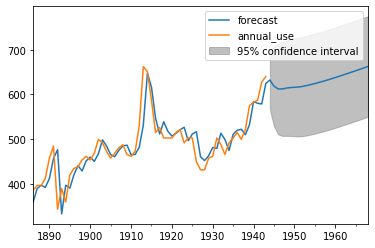

In [38]:
#Forecast untuk 5 tahun kedepan
arima_fit.plot_predict(end='1968')
plt.show()